In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
# import download
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py

In [2]:
keras.__version__


'2.15.0'

In [5]:
pip install opencv-python numpy tensorflow matplotlib h5py



  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/f

In [3]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
    --------------------------------------- 0.6/38.6 MB 13.1 MB/s eta 0:00:03
    --------------------------------------- 0.8/38.6 MB 8.8 MB/s eta 0:00:05
   - -------------------------------------- 1.0/38.6 MB 7.2 MB/s eta 0:00:06
   - -------------------------------------- 1.2/38.6 MB 6.4 MB/s eta 0:00:06
   - -------------------------------------- 1.4/38.6 MB 6.0 MB/s eta 0:00:07
   - -------------------------------------- 1.6/38.6 MB 5.6 MB/s eta 0:00:07
   - -------------------------------------- 1.8/38.6 MB 5.4 MB/s eta 0:00:07
   -- ------------------------------------- 2.0/38.6 MB 5.2 MB/s eta 0:00:08
   -- ------------------------------------- 2.2/38.6 MB 5.1 MB/s eta 0:00:08
   -- ---------

In [3]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [4]:
in_dir = "C:/Users/roshg/Downloads/archive (9)/dataset"

In [5]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".mp4"

In [6]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

In [8]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:1] == 'V':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'NV':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels
print("hello")

hello


In [9]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

In [12]:
names[12]
labels[12]

[0, 1]

In [13]:
frames = get_frames(in_dir, names[12])

In [14]:
visible_frame = (frames*255).astype('uint8')

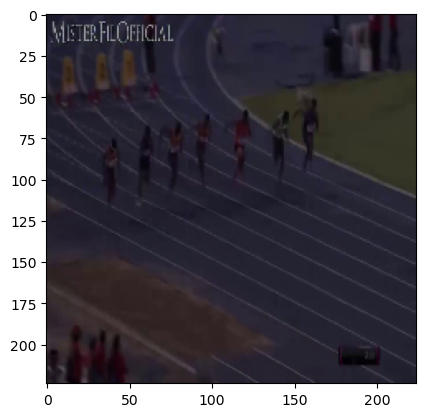

In [15]:
plt.imshow(visible_frame[3])

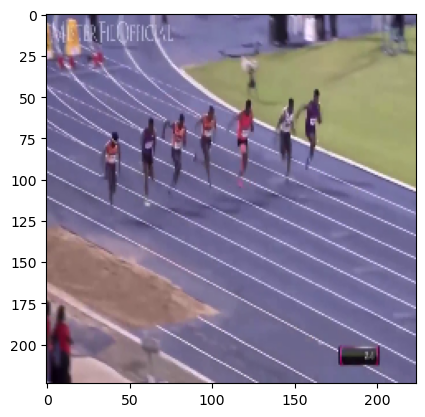

In [16]:
plt.imshow(visible_frame[15])

In [17]:
image_model = VGG16(include_top=True, weights='imagenet')

In [18]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [20]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values


In [21]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [22]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [23]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [24]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [ ]:
make_files(training_set)

1/1 [==============================] - 7s 7s/step
- Progress: 6.4%

In [32]:
make_files_test(test_set)

1/1 [==============================] - 7s 7s/step
- Progress: 99.5%

In [ ]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [34]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [35]:
data, target = process_alldata_training()

In [36]:
data_test, target_test = process_alldata_test()

In [37]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [38]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:720]), np.array(target[0:720]), epochs=epoch,
                    validation_data=(np.array(data[720:]), np.array(target[720:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/200


2/2 - 23s - loss: 0.3045 - accuracy: 0.5139 - val_loss: 0.2468 - val_accuracy: 0.5625 - 23s/epoch - 11s/step
Epoch 2/200
2/2 - 4s - loss: 0.2741 - accuracy: 0.5167 - val_loss: 0.3402 - val_accuracy: 0.4375 - 4s/epoch - 2s/step
Epoch 3/200
2/2 - 5s - loss: 0.2871 - accuracy: 0.5167 - val_loss: 0.2445 - val_accuracy: 0.5625 - 5s/epoch - 3s/step
Epoch 4/200
2/2 - 7s - loss: 0.2566 - accuracy: 0.4833 - val_loss: 0.2455 - val_accuracy: 0.5625 - 7s/epoch - 4s/step
Epoch 5/200
2/2 - 8s - loss: 0.2575 - accuracy: 0.4833 - val_loss: 0.2513 - val_accuracy: 0.4375 - 8s/epoch - 4s/step
Epoch 6/200
2/2 - 7s - loss: 0.2487 - accuracy: 0.5167 - val_loss: 0.2696 - val_accuracy: 0.4375 - 7s/epoch - 3s/step
Epoch 7/200
2/2 - 6s - loss: 0.2537 - accuracy: 0.5167 - val_loss: 0.2581 - val_accuracy: 0.4375 - 6s/epoch - 3s/step
Epoch 8/200
2/2 - 5s - loss: 0.2489 - accuracy: 0.5167 - val_loss: 0.2452 - val_accuracy: 0.6875 - 5s/epoch - 3s/step
Epoch 9/200
2/2 - 5s - loss: 0.2461 - accuracy: 0.6

In [39]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 [==============================] - 1s 104ms/step - loss: 0.0589 - accuracy: 0.9200


In [40]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05892421305179596
accuracy 0.9200000166893005


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


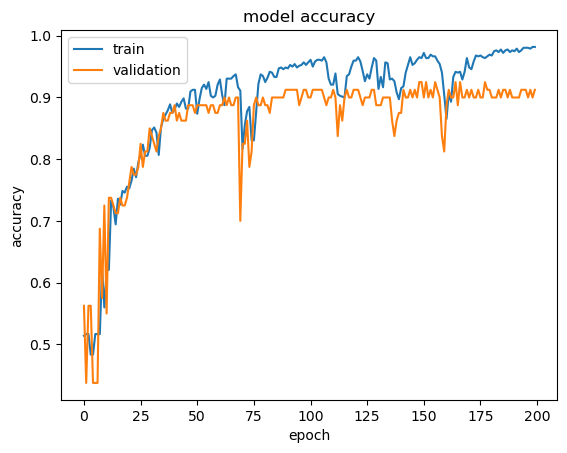

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


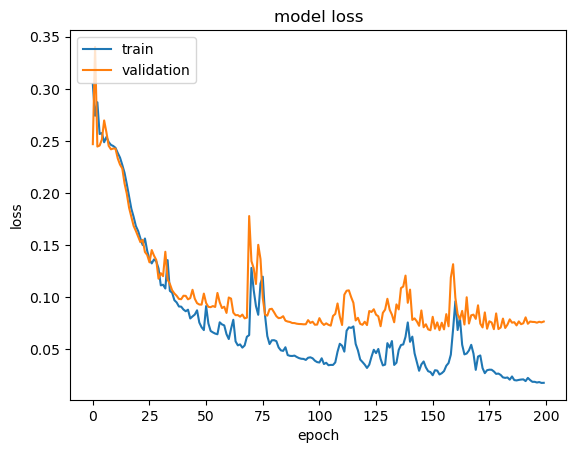

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [45]:
labels_predict = model.predict(np.array(data_test))

7/7 [==============================] - 2s 121ms/step


In [46]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(np.array(target_test) , axis=1)

In [47]:
labels_test_normal.shape , labels_predict.shape

((200,), (200,))

In [48]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.92


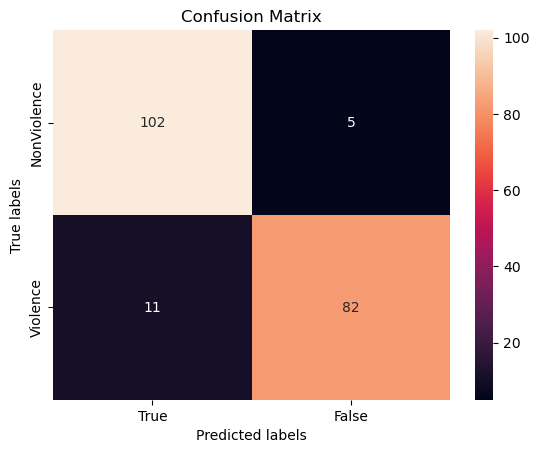

In [49]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [1]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

NameError: name 'labels_test_normal' is not defined

In [80]:
def preprocess_frames(frames, input_size):
    preprocessed_frames = []

    for frame in frames:
        # Resize the frame to match the input size
        frame = cv2.resize(frame, input_size)
        
        # Normalize the pixel values to be in the range [0, 1]
        frame = frame / 255.0
        
        preprocessed_frames.append(frame)

    return preprocessed_frames

In [84]:
model.save('model.h5')

C:\Users\roshg\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
from IPython.display import FileLink
FileLink('model.h5')

C:\Users\roshg\model.h5

In [86]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained CNN+LSTM model
model = load_model('model.h5')  # Update with your model path

# Define parameters for video input
video_path = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_112.mp4'  # Update with the path to your random video
num_frames = 10  # Number of frames to process
frame_shape = (224, 224, 3)  # Match this with the input shape of your model

# Initialize a list to store preprocessed frames
frames = []

# Open the video
cap = cv2.VideoCapture(video_path)

# Read frames from the video
for _ in range(num_frames):
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame (resize to match model input size)
    frame = cv2.resize(frame, frame_shape[:-1])
    frames.append(frame)

# Preprocess the frames to match the input requirements of your model
preprocessed_frames = preprocess_frames(frames,(128,128))  # Implement your own preprocessing function

# Convert the frames to an array
input_data = np.array(preprocessed_frames)[np.newaxis, ...]  # Add a batch dimension

# Perform the prediction
predictions = model.predict(input_data)

# Interpret the predictions (you may have a threshold for classification)
predicted_class = np.argmax(predictions)
if predicted_class == 1:
    prediction_label = "Violence"
else:
    prediction_label = "Non-Violence"

print(f"Prediction: {prediction_label}")

ValueError: in user code:

    File "C:\Users\roshg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\roshg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\roshg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\roshg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\roshg\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\roshg\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 20, 4096), found shape=(None, 0)
